In [1]:
import netCDF4
import xarray as xr
import matplotlib.pyplot as plt
params = {'figure.figsize' : (18, 10),'legend.fontsize': 16,'xtick.labelsize':16,'ytick.labelsize':16,'axes.labelsize':16,'font.size':16}
plt.rcParams.update(params)

import sys
sys.path.insert(0,"/home/ad/alberta/git/xscale")
import xscale

import xscale.spectral.fft as xfft
from xscale.spectral.tools import plot_spectrum
import xscale.signal.generator as xgen

from dask_jobqueue import PBSCluster
from dask.distributed import Client
import dask.dataframe as dd
import dask

import zarr
import os
import glob
import numpy as np

%matplotlib inline


In [6]:
cluster = PBSCluster(
    cores=1,
    memory="120GB",
    project='pangeo',
    processes=1,
    walltime='04:00:00',
    local_directory='$TMPDIR')
cluster

PBSCluster('tcp://10.120.43.22:35545', workers=0, threads=0, memory=0 B)

In [7]:
cluster.scale(20)

In [8]:
client = Client(cluster) # scheduler_file="/home/ad/briolf/scheduler.json")
client

Client Scheduler: tcp://10.120.43.22:35545 Dashboard: http://10.120.43.22:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [9]:
%%time
root = "/work/ALT/odatis/eNATL60/BLBT02/gridT-2D/"
files = sorted(glob.glob(root+'/*.nc'))

drop_vars = [
    'nav_lat',
    'nav_lon',
    'somxl010',
    'sosaline',
    'sosstsst']


open_kwargs = dict(drop_variables=(drop_vars),decode_cf=True, concat_dim="time_counter") #, combine='nested')
dsall = xr.open_mfdataset(files, combine='nested',parallel=True, **open_kwargs)
dsall

CPU times: user 3.81 s, sys: 217 ms, total: 4.03 s
Wall time: 13.5 s


,Array,Chunk
Bytes,93.50 kB,192 B
Shape,"(11688,)","(24,)"
Count,1461 Tasks,487 Chunks
Type,datetime64[ns],numpy.ndarray
,Array,Chunk
Bytes,187.01 kB,384 B
Shape,"(11688, 2)","(24, 2)"
Count,1461 Tasks,487 Chunks
Type,datetime64[ns],numpy.ndarray
,Array,Chunk


In [10]:
dsg=xr.open_dataset('/work/ALT/odatis/eNATL60/mesh_mask_eNATL60_3.6_lev1.nc4')

In [11]:
box=(-90,-60,30,45)
domaineNATL60=(box[0]<dsg.nav_lon)*(dsg.nav_lon<box[1])*(box[2]<dsg.nav_lat)*(dsg.nav_lat<box[3])
whereeNATL60=np.where(domaineNATL60)
jmineNATL60 = whereeNATL60[0].min()
jmaxeNATL60 = whereeNATL60[0].max()
imineNATL60 = whereeNATL60[1].min()
imaxeNATL60 = whereeNATL60[1].max()

print(jmineNATL60,jmaxeNATL60+1,imineNATL60,imaxeNATL60+1)
START_DATE = np.datetime64('2009-07-01')
END_DATE = np.datetime64('2010-06-30')
time_series=dsall['time_counter']
period = (time_series >= START_DATE) & (time_series <= END_DATE)
time=time_series[period]
sshall=dsall.sossheig[period,jmineNATL60:jmaxeNATL60+1,imineNATL60:imaxeNATL60+1]
t=time.values

1510 2800 474 2299


In [12]:
%%time

dsfilt=xr.open_mfdataset("/work/ALT/odatis/eNATL60/outputs/pytide/eNATL60GS-BLBT02_tide-direct_time_M2-S2-N2-O1-K1_y2009m07-y2010m06_k*.nc",combine='nested',
                     concat_dim='time_counter',parallel=True,decode_cf=True) 
dsfilt

CPU times: user 1min 25s, sys: 7.07 s, total: 1min 32s
Wall time: 7min 45s


,Array,Chunk
Bytes,164.99 GB,18.83 MB
Shape,"(8760, 1290, 1825)","(1, 1290, 1825)"
Count,26280 Tasks,8760 Chunks
Type,float64,numpy.ndarray


In [13]:
%%time

ssh_all_GS=sshall[0:8735,2000-jmineNATL60+1,2000-imineNATL60+1]
ssh_pytide_GS=dsfilt.tide[0:8735,2000-jmineNATL60+1,2000-imineNATL60+1]
ssh_filt_GS=ssh_all_GS-ssh_pytide_GS
time=dsall.time_counter[0:8735]

CPU times: user 2.85 s, sys: 105 ms, total: 2.96 s
Wall time: 6.29 s


In [14]:
%%time

ssh_all_GS.load()
ssh_pytide_GS.load()
ssh_filt_GS.load()
time.load()

CPU times: user 16min 58s, sys: 28 s, total: 17min 26s
Wall time: 1h 4min 22s


<xarray.DataArray 'time_counter' (time_counter: 8735)>
array(['2009-06-30T00:30:00.000000000', '2009-06-30T01:30:00.000000000',
       '2009-06-30T02:30:00.000000000', ..., '2010-06-28T20:30:00.000000000',
       '2010-06-28T21:30:00.000000000', '2010-06-28T22:30:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    time_centered  (time_counter) datetime64[ns] 2009-06-30T00:30:00 ... 2010-06-28T22:30:00
  * time_counter   (time_counter) datetime64[ns] 2009-06-30T00:30:00 ... 2010-06-28T22:30:00
Attributes:
    axis:           T
    standard_name:  time
    long_name:      Time axis
    time_origin:    1900-01-01 00:00:00
    bounds:         time_counter_bounds

In [15]:
ssh_filt_GS.shape


(8710,)

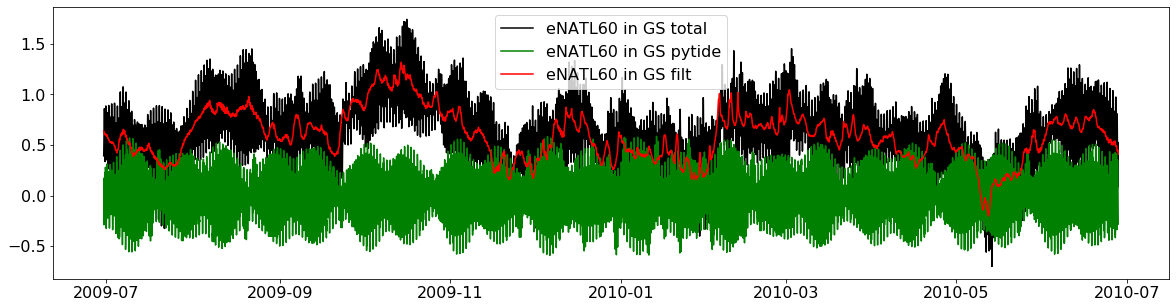

In [16]:
fig=plt.figure(figsize=(20,5))
plt.plot(time[0:8710],ssh_all_GS[0:8710],'k',label='eNATL60 in GS total')
plt.plot(time[0:8710],ssh_pytide_GS[0:8710],'g',label='eNATL60 in GS pytide')
plt.plot(time[0:8710],ssh_filt_GS[0:8710],'r',label='eNATL60 in GS filt')
plt.legend()

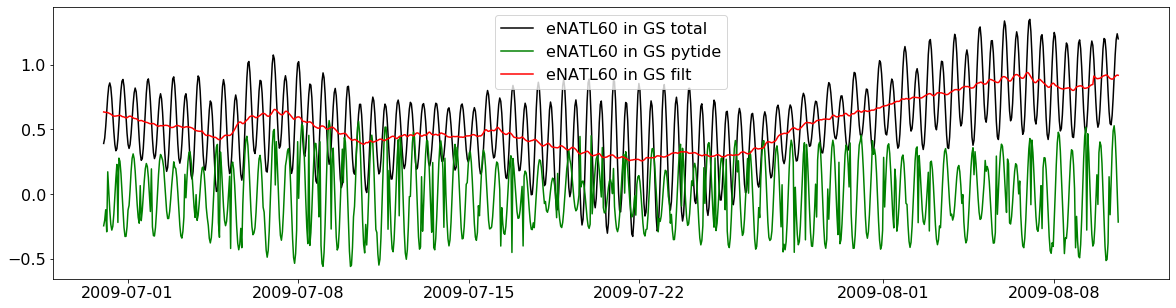

In [17]:
fig=plt.figure(figsize=(20,5))
plt.plot(time[0:1000],ssh_all_GS[0:1000],'k',label='eNATL60 in GS total')
plt.plot(time[0:1000],ssh_pytide_GS[0:1000],'g',label='eNATL60 in GS pytide')
plt.plot(time[0:1000],ssh_filt_GS[0:1000],'r',label='eNATL60 in GS filt')
plt.legend()

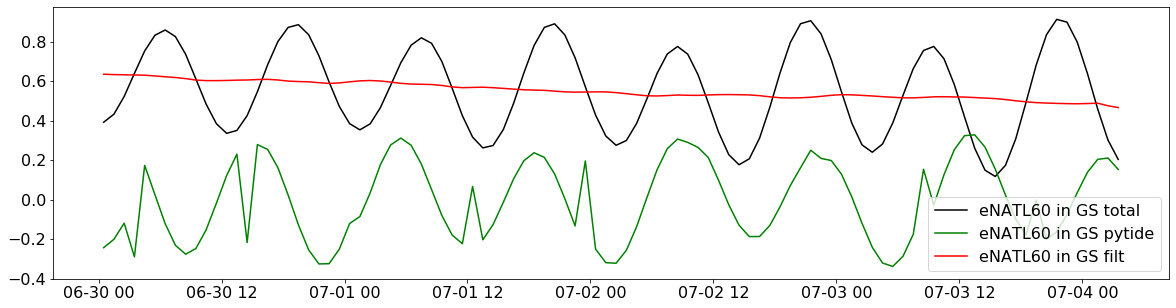

In [18]:
fig=plt.figure(figsize=(20,5))
plt.plot(time[0:100],ssh_all_GS[0:100],'k',label='eNATL60 in GS total')
plt.plot(time[0:100],ssh_pytide_GS[0:100],'g',label='eNATL60 in GS pytide')
plt.plot(time[0:100],ssh_filt_GS[0:100],'r',label='eNATL60 in GS filt')
plt.legend()
plt.savefig('time_series_ssh_filt_pytide_GS_all-freq.png')

In [19]:
NPADDING = 2
SPtime_h = xfft.fft(ssh_all_GS,dim='time_counter', dx=1., detrend='mean',nfft=ssh_all_GS.shape[0]*NPADDING,tapering=True)
MEANPSD_h=xfft.psd(SPtime_h).load()
freqs_h=MEANPSD_h.f_time_counter.values
freqs_h = freqs_h[NPADDING::] 


In [20]:
NPADDING = 2
SPtime_pytide = xfft.fft(ssh_pytide_GS,dim='time_counter', dx=1., detrend='mean',nfft=ssh_pytide_GS.shape[0]*NPADDING,tapering=True)
MEANPSD_pytide=xfft.psd(SPtime_pytide).load()
freqs_pytide=MEANPSD_pytide.f_time_counter.values
freqs_pytide = freqs_pytide[NPADDING::] 


In [21]:
NPADDING = 2
SPtime_hp = xfft.fft(ssh_filt_GS,dim='time_counter', dx=1., detrend='mean',nfft=ssh_filt_GS.shape[0]*NPADDING,tapering=True)
MEANPSD_hp=xfft.psd(SPtime_hp).load()
freqs_hp=MEANPSD_hp.f_time_counter.values
freqs_hp = freqs_hp[NPADDING::] 


Text(0.5, 1.0, 'Temporal Spectrum of eNATL60 SSH in GS')

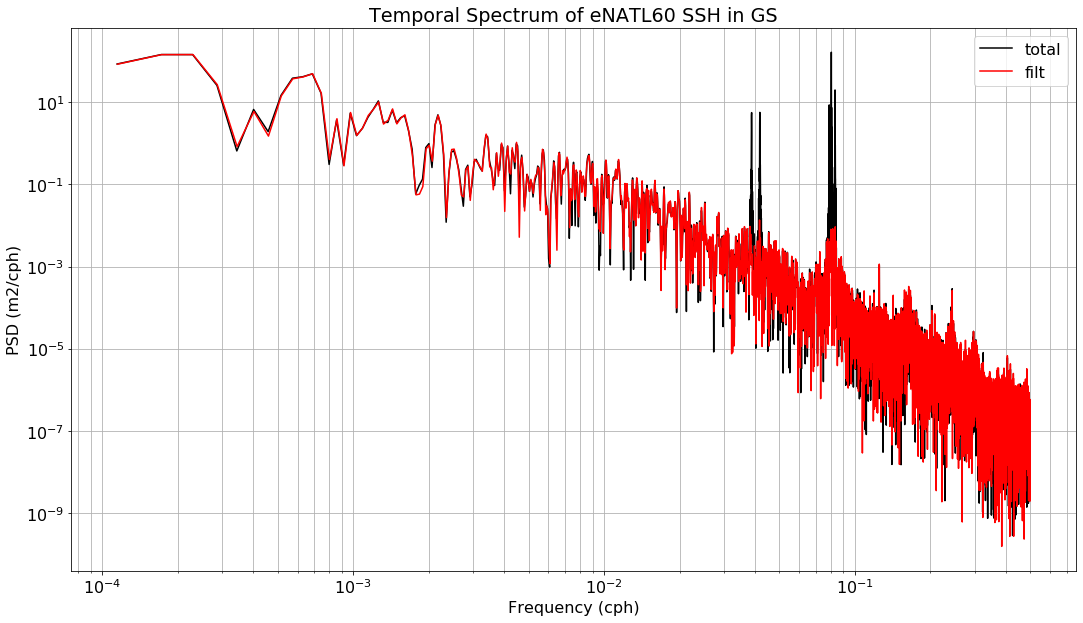

In [22]:
import matplotlib.pyplot as plt
params = {'figure.figsize' : (18, 10),'legend.fontsize': 16,'xtick.labelsize':16,'ytick.labelsize':16,'axes.labelsize':16,'font.size':16}
plt.rcParams.update(params)
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)

ax.loglog(freqs_h,MEANPSD_h[NPADDING::],'k',label='total')
ax.loglog(freqs_hp,MEANPSD_hp[NPADDING::],'r',label='filt')
#ax.loglog(freqs_pytide,MEANPSD_pytide[NPADDING::],'g',label='pytide')
#ax.set_xlim(1e-3,1)
ax.grid(which='both',axis='both')
plt.xlabel('Frequency (cph)')
plt.ylabel('PSD (m2/cph)')
plt.legend()
plt.title('Temporal Spectrum of eNATL60 SSH in GS')

Text(0.5, 1.0, 'Temporal Spectrum of eNATL60 SSH in GS')

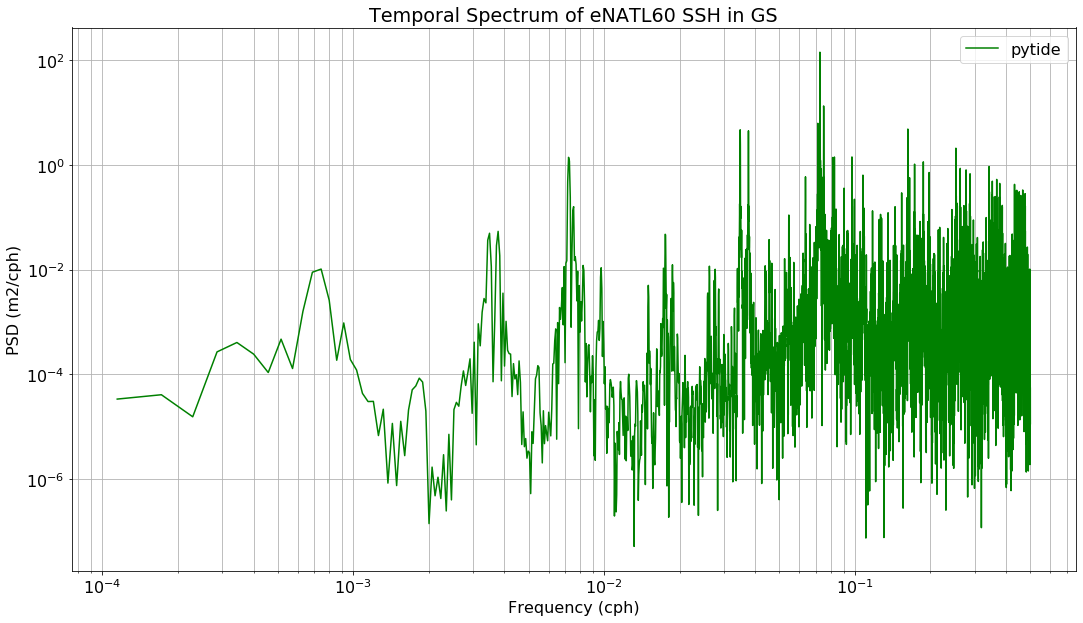

In [23]:
import matplotlib.pyplot as plt
params = {'figure.figsize' : (18, 10),'legend.fontsize': 16,'xtick.labelsize':16,'ytick.labelsize':16,'axes.labelsize':16,'font.size':16}
plt.rcParams.update(params)
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)

#ax.loglog(freqs_h,MEANPSD_h[NPADDING::],'k',label='total')
#ax.loglog(freqs_hp,MEANPSD_hp[NPADDING::],'r',label='filt')
ax.loglog(freqs_pytide,MEANPSD_pytide[NPADDING::],'g',label='pytide')
#ax.set_xlim(1e-3,1)
ax.grid(which='both',axis='both')
plt.xlabel('Frequency (cph)')
plt.ylabel('PSD (m2/cph)')
plt.legend()
plt.title('Temporal Spectrum of eNATL60 SSH in GS')

Text(0.5, 1.0, 'Temporal Spectrum of eNATL60 SSH in GS')

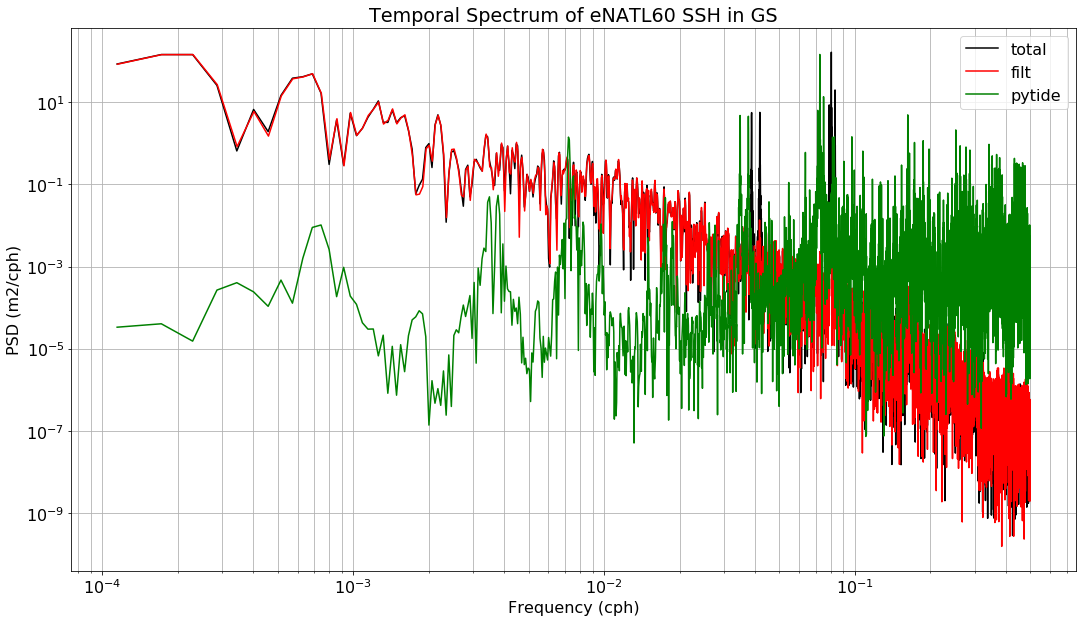

In [24]:
import matplotlib.pyplot as plt
params = {'figure.figsize' : (18, 10),'legend.fontsize': 16,'xtick.labelsize':16,'ytick.labelsize':16,'axes.labelsize':16,'font.size':16}
plt.rcParams.update(params)
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)

ax.loglog(freqs_h,MEANPSD_h[NPADDING::],'k',label='total')
ax.loglog(freqs_hp,MEANPSD_hp[NPADDING::],'r',label='filt')
ax.loglog(freqs_pytide,MEANPSD_pytide[NPADDING::],'g',label='pytide')
#ax.set_xlim(1e-3,1)
ax.grid(which='both',axis='both')
plt.xlabel('Frequency (cph)')
plt.ylabel('PSD (m2/cph)')
plt.legend()
plt.title('Temporal Spectrum of eNATL60 SSH in GS')

Text(0.5, 1.0, 'Temporal Spectrum of eNATL60 SSH in GS')

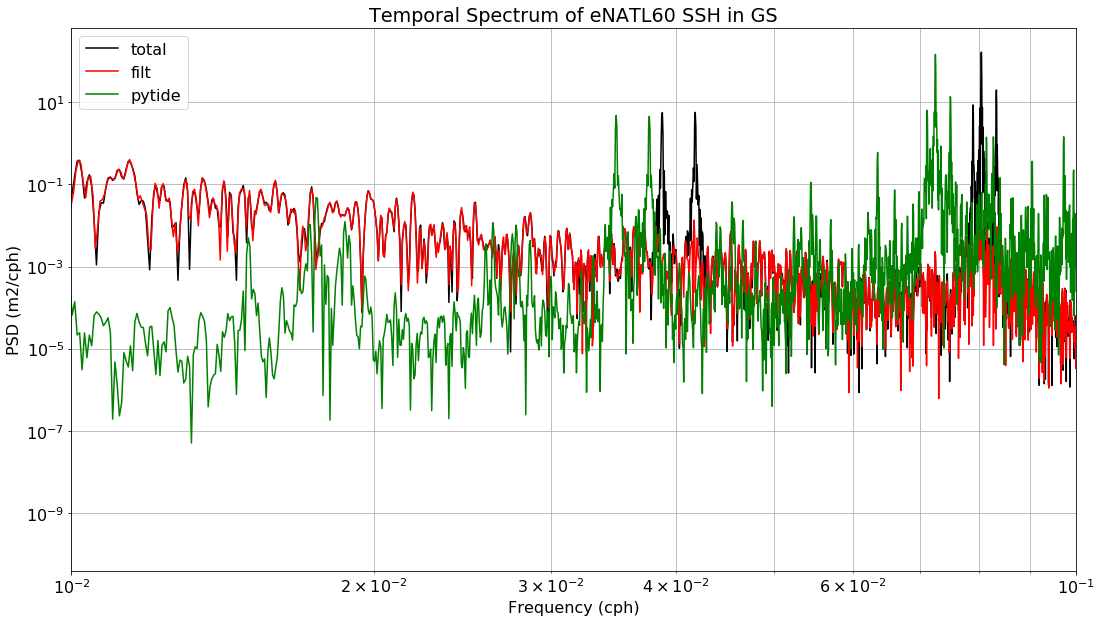

In [25]:
import matplotlib.pyplot as plt
params = {'figure.figsize' : (18, 10),'legend.fontsize': 16,'xtick.labelsize':16,'ytick.labelsize':16,'axes.labelsize':16,'font.size':16}
plt.rcParams.update(params)
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)

ax.loglog(freqs_h,MEANPSD_h[NPADDING::],'k',label='total')
ax.loglog(freqs_hp,MEANPSD_hp[NPADDING::],'r',label='filt')
ax.loglog(freqs_pytide,MEANPSD_pytide[NPADDING::],'g',label='pytide')
ax.set_xlim(1e-2,1e-1)
ax.grid(which='both',axis='both')
plt.xlabel('Frequency (cph)')
plt.ylabel('PSD (m2/cph)')
plt.legend()
plt.title('Temporal Spectrum of eNATL60 SSH in GS')

In [5]:
cluster.close()


distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
